In [476]:
import pandas as pd
import numpy as np
import string


In [477]:
products =pd.read_csv('./data/amazon_baby.csv')
products.dtypes


name      object
review    object
rating     int64
dtype: object

In [478]:
exclude = set(string.punctuation)
print ((exclude))


def remove_punctuation(text):
    instr = str(text)
    for c in exclude:
        #print (c)
        instr = instr.replace(c,"")
    #print ("--",(text,c))
    return instr
        
#products['review']
products['review_clean'] = products['review'].apply(lambda x: remove_punctuation(x))

{'$', '\\', '-', '%', '>', ')', '(', '`', '?', '^', '*', '}', '.', '[', ']', '~', '+', '"', '/', '=', '_', ',', ';', '<', '&', '@', '|', '#', ':', '{', '!', "'"}


In [479]:
products['review_clean']

0         These flannel wipes are OK but in my opinion n...
1         it came early and was not disappointed i love ...
2         Very soft and comfortable and warmer than it l...
3         This is a product well worth the purchase  I h...
4         All of my kids have cried nonstop when I tried...
5         When the Binky Fairy came to our house we didn...
6         Lovely book its bound tightly so you may not b...
7         Perfect for new parents We were able to keep t...
8         A friend of mine pinned this product on Pinter...
9         This has been an easy way for my nanny to reco...
10        I love this journal and our nanny uses it ever...
11        This book is perfect  Im a first time new mom ...
12        I originally just gave the nanny a pad of pape...
13        I thought keeping a simple handwritten journal...
14        Space for monthly photos info and a lot of use...
15        I bought this calender for myself for my secon...
16        I love this little calender yo


3. We will ignore all reviews with rating = 3, since they tend to have a neutral sentiment. 


In [480]:
products = products[products['rating'] != 3]

4. Now, we will assign reviews with a rating of 4 or higher to be positive reviews, while the ones with rating of 2 or lower are negative. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label. A good way is to create an anonymous function that converts a rating into a class label and then apply that function to every element in the rating column. 



In [481]:
products['sentiment'] = products['rating'].apply(lambda rating : 1 if rating > 3 else -1)

In [482]:
#
# load idx files for test and train data
#
import json

with open('data/module-9-assignment-test-idx.json','r') as f:
    test_idx = json.load(f)
f.close()
    
with open ('data/module-9-assignment-train-idx.json','r') as f:
    train_idx = json.load(f)
f.close()

train_data=products.iloc[train_idx]
test_data =products.iloc[test_idx]





In [483]:
len(train_data)


133416

We will now compute the word count for each word that appears in the reviews. A vector consisting of word counts is often referred to as bag-of-word features. Since most words occur in only a few reviews, word count vectors are sparse. For this reason, scikit-learn and many other tools use sparse matrices to store a collection of word count vectors. Refer to appropriate manuals to produce sparse word count vectors. General steps for extracting word count vectors are as follows:

Learn a vocabulary (set of all words) from the training data. Only the words that show up in the training data will be considered for feature extraction.
Compute the occurrences of the words in each review and collect them into a row vector.
Build a sparse matrix where each row is the word count vector for the corresponding review. Call this matrix train_matrix.
Using the same mapping between words and columns, convert the test data into a sparse matrix test_matrix.
The following cell uses CountVectorizer in scikit-learn. Notice the token_pattern argument in the constructor.

In [484]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [485]:
print (train_matrix.shape)
print (train_data['sentiment'].shape)
train_data.head()

(133416, 121713)
(133416,)


,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


In [486]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_matrix,train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [487]:
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(y_true=test_data['sentiment'], y_pred=logreg.predict(test_matrix))

In [488]:
print ("Test Accuracy = ", accuracy_score)

Test Accuracy =  0.932355411567


In [489]:
baseline = (len((test_data[test_data['sentiment'] ==1]))/len(test_data))
print ("Baseline accuracy(majority class classifier):", baseline)

Baseline accuracy(majority class classifier): 0.8427825773938085


** The logreg is better than baseline **

In [490]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=logreg.predict(test_matrix),
                       labels = logreg.classes_) # use the same order of class as the LR model
print('target label | predicted_label |count')
print('-------------+-----------------+-----')
for i, target_label in enumerate(logreg.classes_):
    for j, predicted_label in enumerate(logreg.classes_):
        print('{0:^13}|{1:^15}|{2:5d}'.format(target_label,predicted_label,cmat[i,j]))
       

target label | predicted_label |count
-------------+-----------------+-----
     -1      |      -1       | 3799
     -1      |       1       | 1442
      1      |      -1       |  813
      1      |       1       |27282


** False positive = 1442. False Negative 813. True Negative = 3779. True positive=27282**

 Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints. Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. ** In other words, false positives cost more than false negatives. **(It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)



In [491]:
false_positive=1442
false_negative=813
true_negative=3779
true_positive=27282
false_positive_cost=100
false_negative_cost=1


In [492]:
cost=false_positive_cost*false_positive+false_negative_cost*false_negative

In [493]:
cost

145013

** COST = 145013**

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where precision comes in:


So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher.

First, let us compute the precision of the logistic regression classifier on the test_data. Scikit-learn provides a predefined method for computing precision. (Consult appropriate manuals if you are using other tools.)

In [494]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'], y_pred=logreg.predict(test_matrix))

In [495]:
print ("precision on test data", precision)
logreg.predict(test_matrix)

precision on test data 0.949798078262


array([1, 1, 1, ..., 1, 1, 1])

** Precision = 0.949798078262**

A complementary metric is recall, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:


Let us compute the recall on the test_data. Scikit-learn provides a predefined method for computing recall as well. (Consult appropriate manuals if you are using other tools.)

In [496]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'], y_pred=logreg.predict(test_matrix))
print ("Recall on test data", recall)


Recall on test data 0.971062466631


**Recall on test data 0.971062466631 **

In [497]:
len(test_data)

33336

In [498]:
27282./(true_positive+false_negative)

0.9710624666310731

** recall on all +1 = 1.18 **

In [499]:
def apply_threshold(prob, threshold):
    #print (threshold)
    ret = []
    #print (len(prob))
    for i in prob:
        if i >= threshold:
            ret.append(1)
        else:
            ret.append(-1)
    return ret

Using the model you trained, compute the class probability values P(y=+1|x,w) for the data points in the test_data. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

In [500]:
probabilities = logreg.predict_proba(test_matrix)[:,1]
print (probabilities)
#probabilities[probabilities.
df = pd.DataFrame(probabilities)
print (len(df[df.values < .5]))

[ 0.78019698  0.99999931  0.93225278 ...,  0.99999449  0.99999745
  0.98103756]
4612


In [501]:
predictions_at_fifty = apply_threshold(probabilities,.5)


In [502]:
positives = [x for x in predictions_at_fifty if x > 0]
negatives = [x for x in predictions_at_fifty if x < 0]

In [503]:
len(positives)

28724

In [504]:
len (negatives)

4612

** # of positives at .5 threshold - 28724**

In [505]:
predictions_at_ninety = apply_threshold(probabilities,.9)

In [506]:
ninety_positives = [x for x in predictions_at_ninety if x > 0]
ninety_negatives = [x for x in predictions_at_ninety if x < 0]
print ("postives {0} negatives {1}".format(len(ninety_positives),len(ninety_negatives)))
print (test_matrix[:,1])

postives 25023 negatives 8313



** positives goes to 25023**

In [507]:
ninety_precision = precision_score(y_true=test_data['sentiment'],y_pred=predictions_at_ninety)
fifty_precision = precision_score(y_true=test_data['sentiment'],y_pred=predictions_at_fifty)


print (ninety_precision)
print (fifty_precision)

0.981616912441
0.949798078262


In [508]:
ninety_recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=predictions_at_ninety)
fifty_recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=predictions_at_fifty)
print (ninety_recall)
print (fifty_recall)

0.87428368037
0.971062466631


** precision increases with threshold **

** recall decreases with threshold **

In [509]:
threshold_values = np.linspace(0.5, .9, num=100)
#print (threshold_values)
#precision_all=[]
#recall_all = []
#precision_all.append(fifty_precision)
#precision_all.append(ninety_precision)

#recall_all.append(fifty_recall)
#recall_all.append(ninety_recall)
print (probabilities)

[ 0.78019698  0.99999931  0.93225278 ...,  0.99999449  0.99999745
  0.98103756]


In [510]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

In [511]:
precision_all=[]
recall_all = []
pred = apply_threshold(probabilities,1)
#print (pred)
for i in threshold_values:
    pred = apply_threshold(probabilities,i)
    precis = precision_score(y_true=test_data['sentiment'],y_pred=pred)
    if precis > .965:
        print ("threshold is {0} for precision {1}".format(i, precis))
    precision_all.append(precis)
    #fifty_precision = precision_score(y_true=test_data['sentiment'],y_pred=predictions_at_fifty)
    recall_all.append(recall_score(y_true=test_data['sentiment'], y_pred=pred))

print (precision_all)
#print (recall_all)

threshold is 0.706060606060606 for precision 0.9650754587238971
threshold is 0.7101010101010101 for precision 0.9653623188405797
threshold is 0.7141414141414142 for precision 0.9655860168262257
threshold is 0.7181818181818181 for precision 0.9658752631961083
threshold is 0.7222222222222222 for precision 0.9661626808170386
threshold is 0.7262626262626263 for precision 0.9664131581820167
threshold is 0.7303030303030303 for precision 0.9667419495847297
threshold is 0.7343434343434343 for precision 0.9670678336980306
threshold is 0.7383838383838384 for precision 0.967501643175345
threshold is 0.7424242424242424 for precision 0.9679236311766212
threshold is 0.7464646464646465 for precision 0.9680111265646731
threshold is 0.7505050505050506 for precision 0.968198138785081
threshold is 0.7545454545454545 for precision 0.9687431212854941
threshold is 0.7585858585858586 for precision 0.9692805173807599
threshold is 0.7626262626262627 for precision 0.9694406648769904
threshold is 0.7666666666666

Using threshold = 0.98, how many false negatives do we get on the test_data? This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

In [512]:
t = 0.98
predictions_at_98 = apply_threshold(probabilities,t)
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=predictions_at_98,
                       labels = logreg.classes_) # use the same order of class as the LR model
print('target label | predicted_label |count')
print('-------------+-----------------+-----')
for i, target_label in enumerate(logreg.classes_):
    for j, predicted_label in enumerate(logreg.classes_):
        print('{0:^13}|{1:^15}|{2:5d}'.format(target_label,predicted_label,cmat[i,j]))
       


target label | predicted_label |count
-------------+-----------------+-----
     -1      |      -1       | 5047
     -1      |       1       |  194
      1      |      -1       | 8282
      1      |       1       |19813


** false negatives = 8282 for .98 threshold**

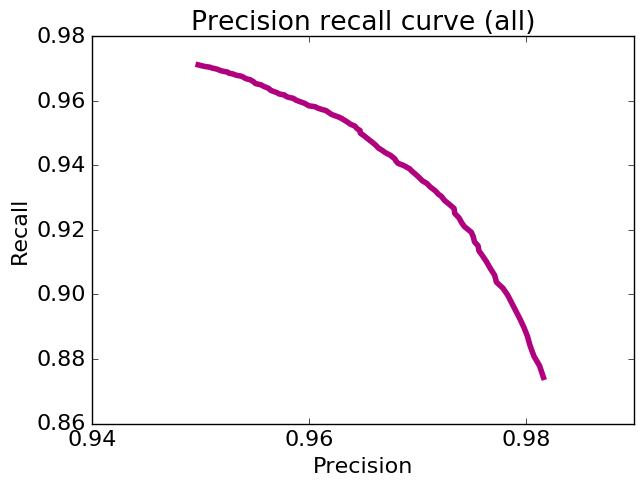

In [513]:
import matplotlib.pyplot as plt
%matplotlib inline
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [514]:
test_data['name'].apply(lambda x: 'baby' in str(x).lower())

9          True
10         True
16        False
20        False
28        False
36        False
37        False
41        False
43        False
56         True
59         True
71        False
91        False
112        True
115        True
116       False
120       False
123       False
129       False
135       False
140       False
146       False
149       False
157       False
158       False
160       False
164       False
171       False
177       False
180       False
          ...  
183365    False
183370    False
183377    False
183388    False
183393     True
183397     True
183404    False
183405     True
183406     True
183414     True
183415    False
183418    False
183434    False
183436    False
183447    False
183456    False
183459     True
183460    False
183461    False
183465     True
183468    False
183473    False
183483    False
183487    False
183499    False
183507    False
183515    False
183522    False
183524    False
183530     True
Name: name, dtype: bool

In [515]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in str(x).lower())]

In [516]:
len(baby_reviews)

6611

In [517]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
baby_probabilities = logreg.predict_proba(baby_matrix)[:,1]

In [518]:
threshold_values = np.linspace(0.5, 1, num=100)

In [519]:
baby_precision= []
baby_recall = []
for i in threshold_values:
    baby_pred = apply_threshold(baby_probabilities,i)
    precis = precision_score(y_true=baby_reviews['sentiment'],y_pred=baby_pred)
    if precis > .965:
        print ("threshold is {0} for precision {1}".format(i, precis))
    baby_precision.append(precis)
    baby_recall.append(recall_score(y_true=baby_reviews['sentiment'], y_pred=baby_pred))

    

threshold is 0.7272727272727273 for precision 0.9656331714605902
threshold is 0.7323232323232324 for precision 0.966142910587355
threshold is 0.7373737373737375 for precision 0.9666666666666667
threshold is 0.7424242424242424 for precision 0.9676934635612322
threshold is 0.7474747474747475 for precision 0.9680210684725358
threshold is 0.7525252525252526 for precision 0.9683675390698551
threshold is 0.7575757575757576 for precision 0.9688737973967176
threshold is 0.7626262626262627 for precision 0.9688208616780045
threshold is 0.7676767676767677 for precision 0.9693181818181819
threshold is 0.7727272727272727 for precision 0.9694728858551385
threshold is 0.7777777777777778 for precision 0.9703365658870508
threshold is 0.7828282828282829 for precision 0.9704874333587205
threshold is 0.7878787878787878 for precision 0.9704311331552843
threshold is 0.7929292929292929 for precision 0.9705601223475435
threshold is 0.797979797979798 for precision 0.9712698716720934
threshold is 0.803030303030

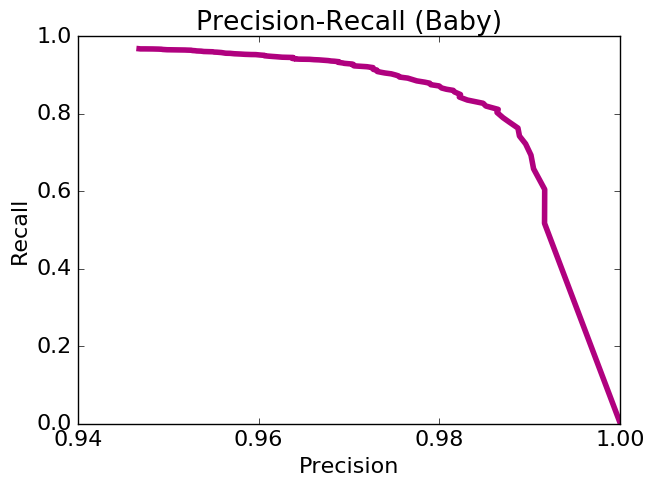

In [520]:
plot_pr_curve(baby_precision, baby_recall, "Precision-Recall (Baby)")